In [1]:
import torch
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
df = pd.read_csv('ems_data.csv')
df.head()

Unnamed: 0 Original Call for Service Type  Final Call for Service Type  \
0           0     Chest Pain (Non-Traumatic)   Chest Pain (Non-Traumatic)   
1           1         Assault/Sexual Assault       Assault/Sexual Assault   
2           2     Unknown Problem (Man Down)   Unknown Problem (Man Down)   
3           3           Convulsions/Seizures         Convulsions/Seizures   
4           4    Unconscious/Fainting (Near)  Unconscious/Fainting (Near)   

  Incident Date  ZIP Code  Aldermanic District  
0    12/30/2018     53206                   15  
1    12/30/2018         0                   15  
2    12/30/2018     53210                   10  
3    12/30/2018     53233                    4  
4    12/30/2018     53209                    1

In [3]:
values = (df['Final Call for Service Type'] != df['Original Call for Service Type']).astype('int')
data_types = {'Original Call for Service Type': 'category',
          'Final Call for Service Type': 'category',
          'ZIP Code': 'category',
          'Aldermanic District': 'category',}
    
df = df.astype(data_types)
df['Incident Date'] = pd.to_datetime(df['Incident Date'])

In [4]:
df['Day'] = df['Incident Date'].dt.day
df['Month'] = df['Incident Date'].dt.month
df['Year'] = df['Incident Date'].dt.year
df['Weekday'] = df['Incident Date'].dt.dayofweek

In [5]:
values.value_counts()

0    658980
1     56661
dtype: int64

In [5]:
features = df[['Original Call for Service Type', 'ZIP Code',
       'Aldermanic District', 'Day', 'Month', 'Year', 'Weekday']]
features['Original Call for Service Type'] = features['Original Call for Service Type'].cat.codes

<ipython-input-5-a26e2d11589b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Original Call for Service Type'] = features['Original Call for Service Type'].cat.codes


In [6]:
X = torch.tensor(features.values)
y = torch.tensor(values)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1, stratify = y)

In [7]:
N, D_in, H, D_out = X_train.shape[0], X_train.shape[1], 35, 1

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
)
losses = []
def loss_fn(pred, true):
    return ((pred-true)**2).mean()
learning_rate = 1e-4
for t in range(1, 5001):
    y_pred = model(X_train.float())
    loss = loss_fn(torch.reshape(y_pred, (-1,)), y_train)
    losses.append(loss.item())
    if t % 100 == 0:
        y_pred = model(X_test.float())
        test_loss = loss_fn(torch.reshape(y_pred, (-1,)), y_test)
        print('Generation', t, 'loss:', test_loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

Generation 100 loss: 0.13568730652332306
Generation 200 loss: 0.12467486411333084
Generation 300 loss: 0.11756887286901474
Generation 400 loss: 0.11244043707847595
Generation 500 loss: 0.10835381597280502
Generation 600 loss: 0.10485275089740753
Generation 700 loss: 0.10171284526586533
Generation 800 loss: 0.09882145375013351
Generation 900 loss: 0.09612048417329788
Generation 1000 loss: 0.09357811510562897
Generation 1100 loss: 0.09117568284273148
Generation 1200 loss: 0.08890066295862198
Generation 1300 loss: 0.08674415200948715
Generation 1400 loss: 0.08469890058040619
Generation 1500 loss: 0.08275848627090454
Generation 1600 loss: 0.08091732114553452
Generation 1700 loss: 0.07917017489671707
Generation 1800 loss: 0.07751217484474182
Generation 1900 loss: 0.0759386420249939
Generation 2000 loss: 0.07444535940885544
Generation 2100 loss: 0.07302812486886978
Generation 2200 loss: 0.0716831162571907
Generation 2300 loss: 0.07040661573410034
Generation 2400 loss: 0.06919509917497635
Gen

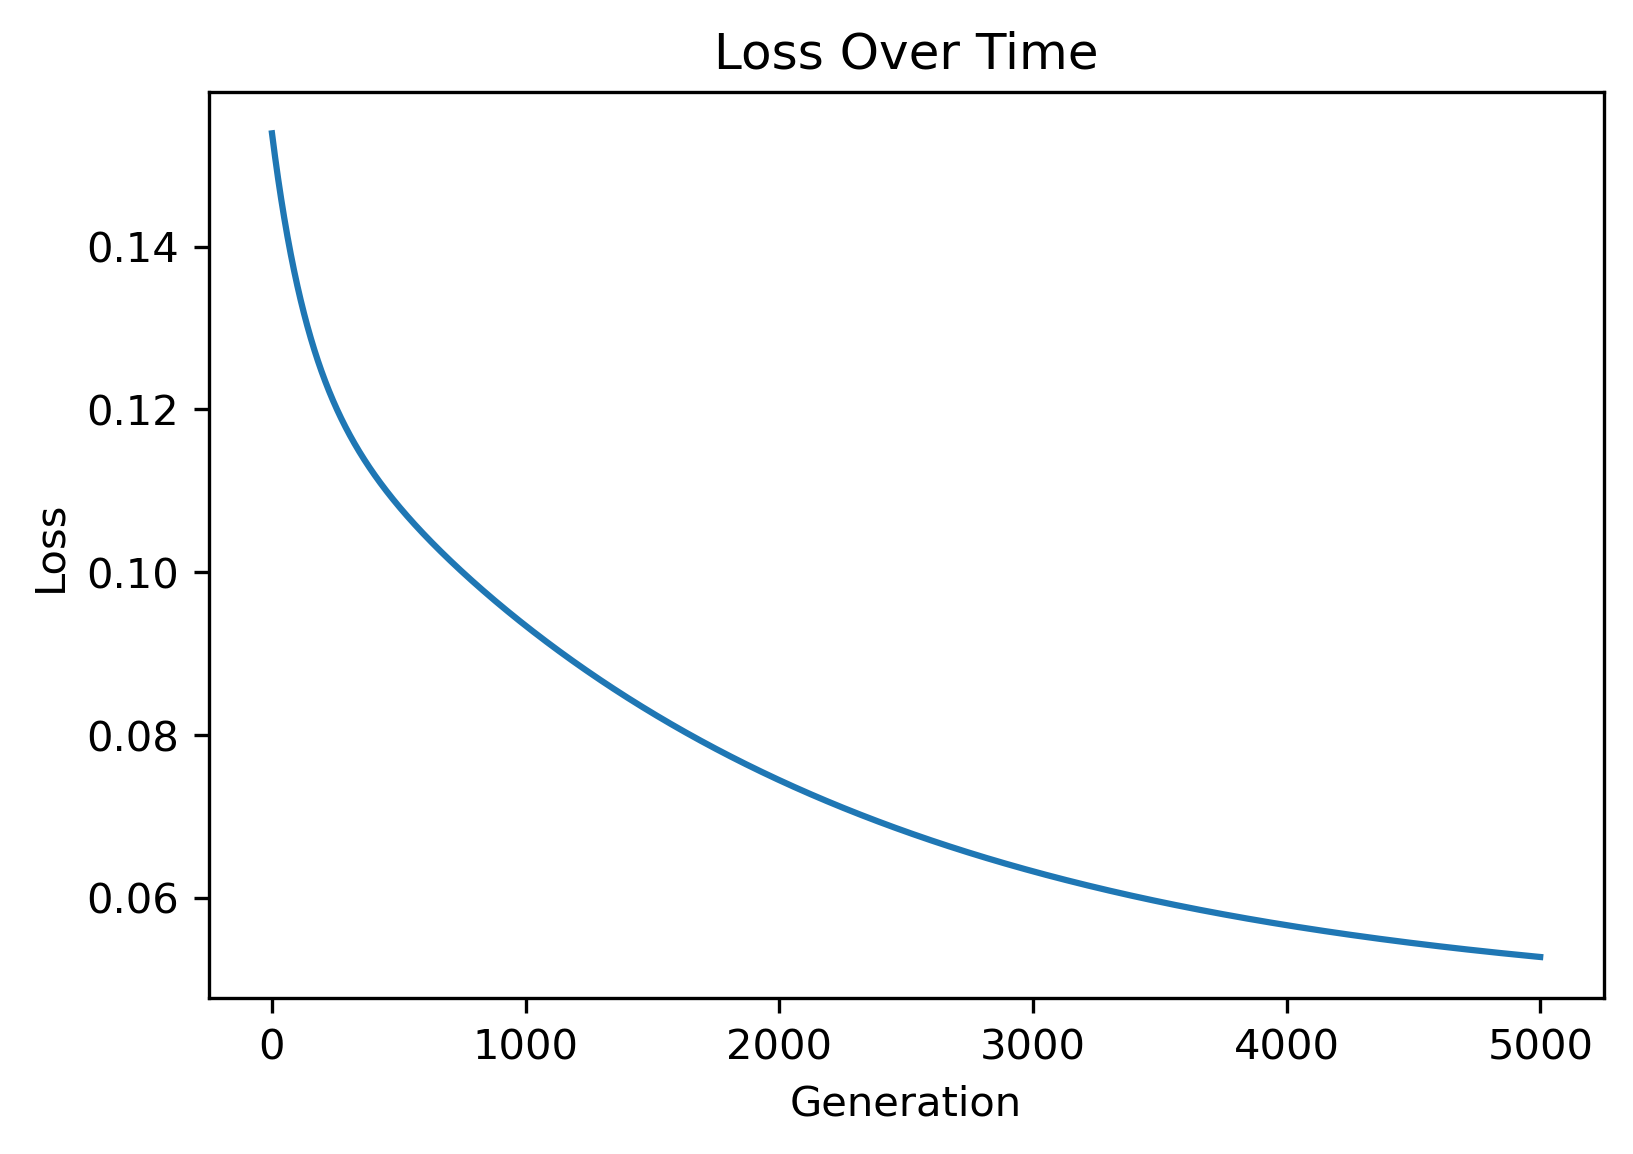

In [10]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title('Loss Over Time')
ax.set_xlabel('Generation')
ax.set_ylabel('Loss')
plt.show()